In [1]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, SimpleRNN, LSTM
from keras.models import Sequential
from keras.initializers import Constant
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import regularizers

Using TensorFlow backend.


In [2]:
BASE_DIR = ''
MAX_SEQUENCE_LENGTH = 2000
MAX_NUM_WORDS = 4000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [3]:
text=[]
sentiment=[]
with open('clean-data.json','r') as f:
    d = json.load(f)
    text.extend(d['text'].values())
    sentiment.extend(d['sentiment'].values())

X=text
Y=sentiment

In [4]:
X=[]
Y=[]
for i in range(len(sentiment)):
    if sentiment[i]!='neutral':
        X.append(text[i])
        Y.append(1 if sentiment[i]=='positive' else 0)

In [5]:
train_x=[]
train_y=[]#mark 1 as positive 0 as negative

file_list = os.listdir('aclImdb/train/pos')
for file in file_list:
    with open('aclImdb/train/pos/'+file,'rb') as f:
        s = f.read().decode('utf8')
        train_x.append(s)
pos_num=len(train_x)
train_y.extend([1]*pos_num)

file_list = os.listdir('aclImdb/train/neg')
for file in file_list:
    with open('aclImdb/train/neg/'+file,'rb') as f:
        s = f.read().decode('utf8')
        train_x.append(s)
neg_num=len(train_x)-pos_num
train_y.extend([0]*neg_num)

In [6]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open('glove.6B.100d.txt',encoding='utf-8') as f:
    
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [10]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_x)

sequences = tokenizer.texts_to_sequences(train_x)
sequences_test = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [11]:
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [12]:
x_train.shape

(25000, 2000)

In [13]:
x_train[1]

array([  0,   0,   0, ...,   5, 335, 405])

In [14]:
#first column represent positive
def buildy(i):
    return [1,0] if i==1 else [0,1]
y_train=[buildy(y) for y in train_y]
y_test=[buildy(y) for y in Y]
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)

In [15]:
y_train.shape

(25000, 2)

In [16]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [27]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(17))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 100)         400100    
_________________________________________________________________
lstm_3 (LSTM)                (None, 17)                8024      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 36        
Total params: 408,160
Trainable params: 8,060
Non-trainable params: 400,100
_________________________________________________________________


In [31]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 323s 16ms/step - loss: 0.6050 - acc: 0.6742 - val_loss: 1.5862 - val_acc: 0.0532
Epoch 2/10
20000/20000 [==============================] - 318s 16ms/step - loss: 0.5362 - acc: 0.7407 - val_loss: 0.5220 - val_acc: 0.8102
Epoch 3/10
20000/20000 [==============================] - 310s 15ms/step - loss: 0.4813 - acc: 0.7754 - val_loss: 0.4699 - val_acc: 0.7962
Epoch 4/10
20000/20000 [==============================] - 296s 15ms/step - loss: 0.4382 - acc: 0.8037 - val_loss: 0.6618 - val_acc: 0.6930
Epoch 5/10
20000/20000 [==============================] - 247s 12ms/step - loss: 0.4042 - acc: 0.8211 - val_loss: 0.5470 - val_acc: 0.7268
Epoch 6/10
20000/20000 [==============================] - 247s 12ms/step - loss: 0.3817 - acc: 0.8315 - val_loss: 0.6552 - val_acc: 0.6920
Epoch 7/10
20000/20000 [==============================] - 247s 12ms/step - loss: 0.3652 - acc: 0.8405 - val_loss: 0.5

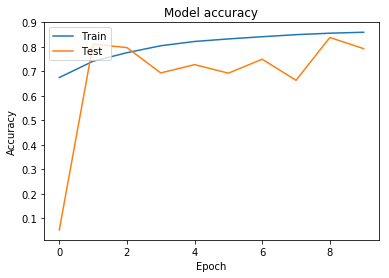

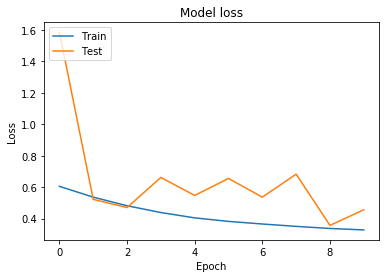

In [32]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [33]:
y_pred = model.predict(x_test)
def bina(li):
    if li[0]>li[1]  :
        return 1
    return 0
y_pre=[bina(y) for y in y_pred]
y_tes=[bina(y) for y in y_test]

In [35]:
import math
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
#from pandas_ml import ConfusionMatrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import itertools

In [36]:
cm=confusion_matrix(y_true=y_tes,y_pred=y_pre,labels=[1,0])
print(cm)

[[483  38]
 [222  43]]


In [37]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

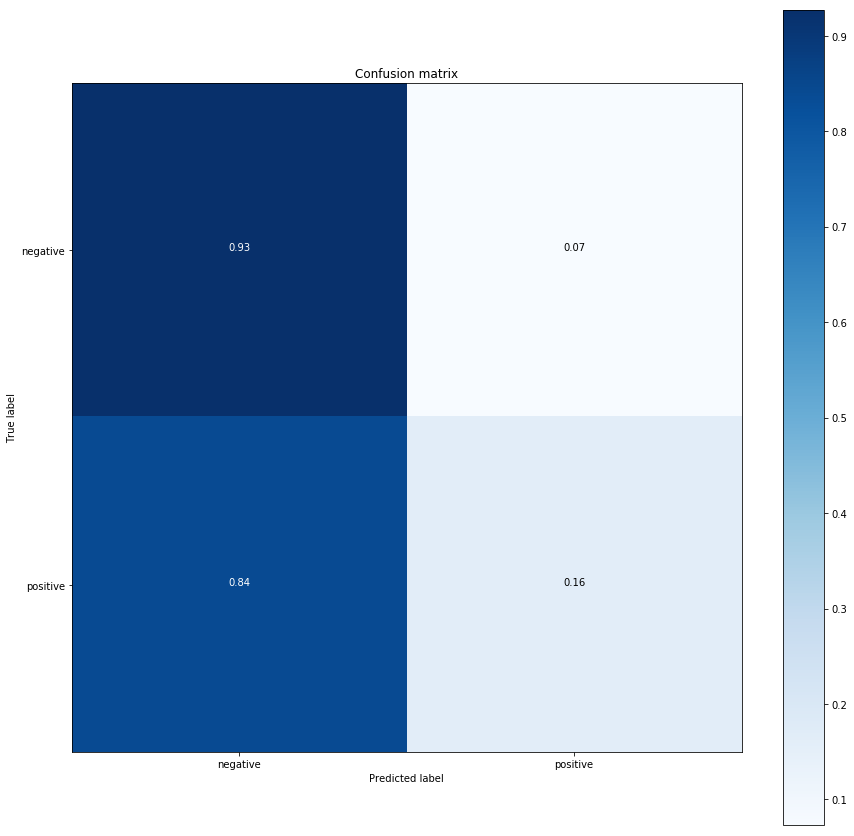

In [39]:
text_labels = ['negative','positive']

plt.figure(figsize=(15,15))
plot_confusion_matrix(cm, classes=text_labels, title="Confusion matrix")
plt.show()